In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from numpy.random import default_rng
import squidpy as sq
import pandas as pd
import anndata as ad
from pathlib import Path
from jax.config import config
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import delayed, Parallel
from anndata import AnnData
import mplscience
from tqdm import tqdm
import itertools
from scipy import stats

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1
config.update("jax_enable_x64", True)
# # sc.set_figure_params()
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/moscot_paper/benchmarks/space/sink_brain/adata_aligned_section1.h5ad"
)
# sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

## Compute spatial neighbors

In [3]:
sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs=30)
batch = "batch_final"
_, idx = adata.obsp["spatial_connectivities"][adata.obs[batch].isin(["0"]), :].nonzero()
adata_temp = adata[idx].copy()

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Compute L1 wasserstein

In [4]:
def compute_w(gene, adata_temp):
    l = []
    for b1, b2 in zip(["0", "0"], ["1", "2"]):
        df = sc.get.obs_df(
            adata_temp[adata_temp[:, gene].X.A.flatten() > 0], [batch, gene]
        )
        df_sample1 = df[df[batch] == b1]
        df_sample2 = df[df[batch] == b2]
        w = stats.wasserstein_distance(
            df_sample1[gene].values,
            df_sample2[gene].values,
        )
        l.append(
            {
                "batch_ref": b1,
                "batch_query": b2,
                "stat": w,
                "gene": gene,
                "len_batch_ref": len(df_sample1),
                "len_batch_query": len(df_sample2),
                "mean_exp": np.mean(
                    [df_sample1[gene].values.mean(), df_sample2[gene].values.mean()]
                ),
            }
        )
    return l


res = Parallel(n_jobs=10)(
    delayed(compute_w)(gene, adata_temp) for gene in adata.var_names
)

In [5]:
df = pd.DataFrame(list(itertools.chain(*res)))
df.sort_values(by="stat")

,batch_ref,batch_query,stat,gene,len_batch_ref,len_batch_query,mean_exp
535,0,2,0.003605,Gpr63,266319,230524,0.605266
18,0,1,0.003755,Htr5a,258237,137540,0.543448
26,0,1,0.004730,Adora1,643512,350770,1.120804
22,0,1,0.005906,Htr6,111004,62004,0.475895
537,0,2,0.006147,Gpr75,396288,312614,0.647605
...,...,...,...,...,...,...,...
758,0,1,0.436279,Gad1,345061,196734,2.055013
53,0,2,0.440845,Adgrl1,809806,746586,1.661590
41,0,2,0.444926,Adgrb1,761136,694289,1.589386
147,0,2,0.459291,Cxcr5,2298,3395,0.786087


## Top genes

<Axes: xlabel='Htr5a', ylabel='Density'>

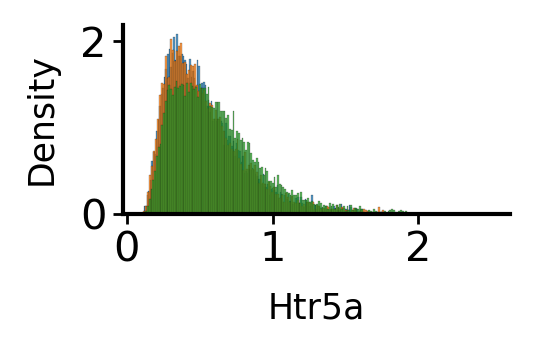

In [6]:
gene = "Htr5a"
df_temp = sc.get.obs_df(
    adata_temp[adata_temp[:, gene].X.A.flatten() > 0], [batch, gene]
)

fig, ax = plt.subplots(figsize=(2, 1), dpi=250)

sns.histplot(data=df_temp[df_temp[batch] == "0"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "1"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "2"], x=gene, stat="density", ax=ax)

<Axes: xlabel='Gpr63', ylabel='Density'>

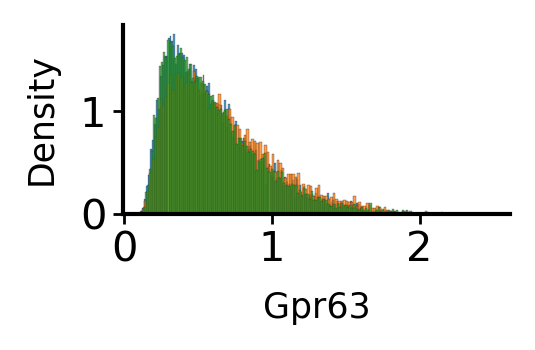

In [8]:
gene = "Gpr63"
df_temp = sc.get.obs_df(
    adata_temp[adata_temp[:, gene].X.A.flatten() > 0], [batch, gene]
)

fig, ax = plt.subplots(figsize=(2, 1), dpi=250)

sns.histplot(data=df_temp[df_temp[batch] == "0"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "1"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "2"], x=gene, stat="density", ax=ax)

## Bottom genes

<Axes: xlabel='Slc32a1', ylabel='Density'>

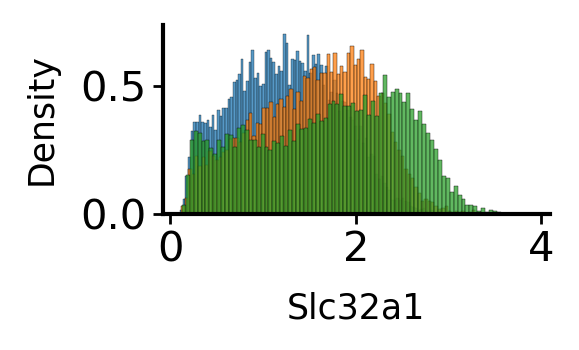

In [9]:
gene = "Slc32a1"
df_temp = sc.get.obs_df(
    adata_temp[adata_temp[:, gene].X.A.flatten() > 0], [batch, gene]
)

fig, ax = plt.subplots(figsize=(2, 1), dpi=250)

sns.histplot(data=df_temp[df_temp[batch] == "0"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "1"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "2"], x=gene, stat="density", ax=ax)

<Axes: xlabel='Cxcr5', ylabel='Density'>

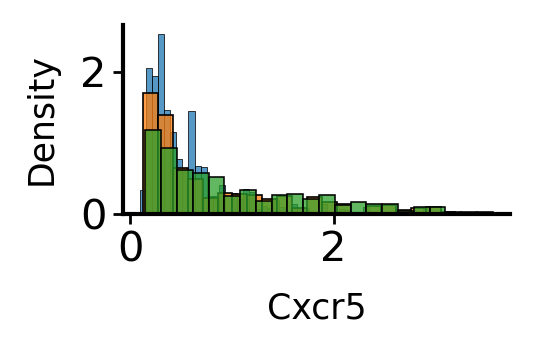

In [10]:
gene = "Cxcr5"
df_temp = sc.get.obs_df(
    adata_temp[adata_temp[:, gene].X.A.flatten() > 0], [batch, gene]
)

fig, ax = plt.subplots(figsize=(2, 1), dpi=250)

sns.histplot(data=df_temp[df_temp[batch] == "0"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "1"], x=gene, stat="density", ax=ax)
sns.histplot(data=df_temp[df_temp[batch] == "2"], x=gene, stat="density", ax=ax)

## Dependency between mean expression and distance

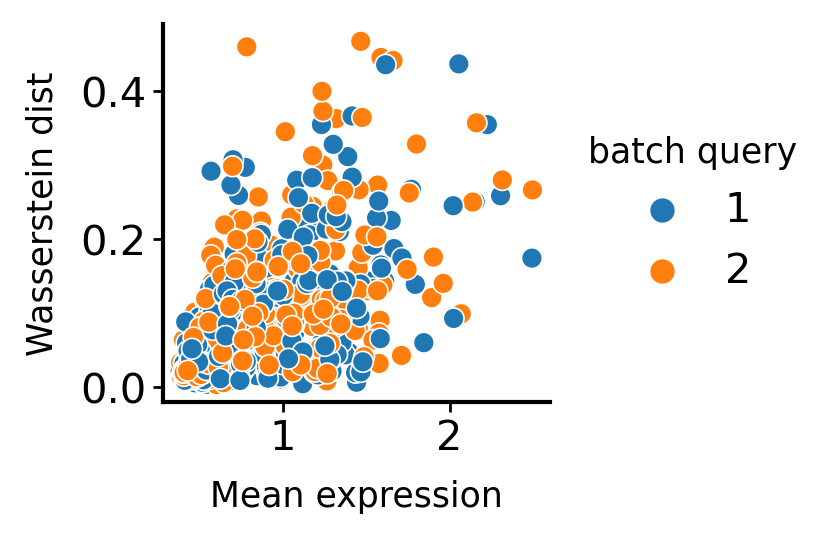

In [12]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=250)
sns.scatterplot(data=df, x="mean_exp", y="stat", hue="batch_query", ax=ax)
plt.xlabel("Mean expression")
plt.ylabel("Wasserstein dist")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="batch query")

## Distribution of wasserstein

<Axes: xlabel='stat', ylabel='Density'>

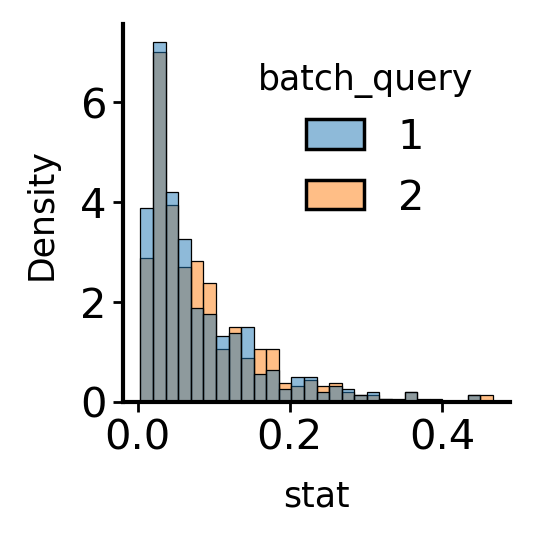

In [16]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=250)
sns.histplot(data=df, x="stat", stat="density", hue="batch_query", ax=ax)